# Duration & Timestep Sensitivity Analysis

Analyze how `sim_duration`, `prj_duration`, and `timestep` independently influence optimization results.

## Objectives
1. Understand how simulation duration affects investment decisions (seasonal coverage)
2. Understand how project duration affects CAPEX/OPEX tradeoffs
3. Understand how timestep resolution affects accuracy vs compute time

## 1. Motivation

REVOLETION's default parameters (50-day simulation, 25-year project, 15-min timestep) represent tradeoffs:

**Simulation Duration (`sim_duration`)**
- Default 50 days = 13.7% of a year
- Longer durations capture seasonal variability in:
  - PV irradiance (summer vs winter)
  - Electricity demand patterns
  - Grid prices (if time-of-use)
- Trade-off: accuracy vs computation time

**Project Duration (`prj_duration`)**
- Affects how CAPEX is amortized over the planning horizon
- Longer horizons favor higher upfront investments (more time to recoup)
- Shorter horizons may prefer lower CAPEX solutions

**Timestep Resolution (`timestep`)**
- 15-min: Captures short-term dynamics (EV charging peaks, PV fluctuations)
- 30-min/60-min: Faster computation but smooths out peaks
- Affects sizing accuracy for power-limited components

---

### Critical: The `compensate_sim_prj` Mechanism

**Problem**: The optimizer only "sees" costs inside the simulated time window. Without compensation:
- Short simulations → CAPEX dominates → underinvestment
- Long simulations → OPEX dominates → overinvestment

**Solution**: `compensate_sim_prj=True` rescales CAPEX and OPEX so costs reflect the **entire project duration**, not just the simulated period.

**How it works:**
- **CAPEX compensation**: Converts specific CAPEX into an *equivalent present cost over the whole project lifetime* via `annuity_due_capex()`
- **OPEX compensation**: Scales simulated OPEX to yearly OPEX, then discounts over project duration via `annuity_recur()`

### Why Longer sim_duration Can Cause "Unbounded" Errors

Simply increasing `sim_duration` without adjusting other parameters can cause **"Infeasible or Unbounded"** errors:

1. **Root cause**: When `sim_duration` increases but `prj_duration` stays fixed, the compensation ratio changes
   - The compensation factor becomes smaller (e.g., 180d/5y vs 50d/5y)
   - CAPEX appears relatively cheaper compared to OPEX
   - With `invest_max=None`, optimizer invests infinitely

2. **Why "unbounded" instead of "very large"?** 
   - LP solver mathematically proves no finite optimum exists
   - Marginal benefit (avoided OPEX) exceeds marginal cost (CAPEX) at all scales
   - Solver reports "unbounded" rather than iterating to infinity

3. **Solution for multi-stage optimization**:
   ```
   sim_duration = 180       # seasonal coverage (2 seasons)
   prj_duration = 5         # = stage duration
   compensate_sim_prj = True  # keeps CAPEX/OPEX balanced
   invest_max = reasonable    # prevents unbounded (STRIDE calculates this automatically)
   ```

## 2. Setup

In [1]:
import json
import time
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Imports successful")

Imports successful


In [2]:
# Setup paths
REPO_ROOT = Path("/Users/arnoclaude/Documents/TUM/Thesis/STRIDE")
NOTEBOOK_DIR = REPO_ROOT / "notebooks" / "03_test_sim_prj_timestep_durations"
SCENARIO_DIR = NOTEBOOK_DIR / "scenarios"
RESULTS_DIR = NOTEBOOK_DIR / "results"
OUTPUT_DIR = NOTEBOOK_DIR / "output"
FIG_DIR = OUTPUT_DIR / "figures"
REVOLETION_DIR = REPO_ROOT / "revoletion"
SETTINGS_FILE = SCENARIO_DIR / "settings.csv"

# Create directories
RESULTS_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

# Python interpreter (venv)
PYTHON_PATH = "/Users/arnoclaude/Documents/TUM/Thesis/thesis-optimization/venv/bin/python3"

print(f"Notebook dir: {NOTEBOOK_DIR}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Output dir: {OUTPUT_DIR}")

Notebook dir: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/03_test_sim_prj_timestep_durations
Results dir: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/03_test_sim_prj_timestep_durations/results
Output dir: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/03_test_sim_prj_timestep_durations/output


In [3]:
def run_revoletion(scenario_file: Path, timeout: int = 1800) -> tuple[dict, float]:
    """
    Run REVOLETION optimization and return results + runtime.
    
    Args:
        scenario_file: Path to scenario CSV
        timeout: Max runtime in seconds (default 30 min)
    
    Returns:
        (results_dict, runtime_seconds)
    """
    print(f"\nRunning: {scenario_file.name}")
    print("="*60)
    
    start_time = time.time()
    
    result = subprocess.run(
        [PYTHON_PATH, '-m', 'revoletion.main',
         '--settings', str(SETTINGS_FILE),
         '--scenario', str(scenario_file)],
        cwd=str(REVOLETION_DIR),
        capture_output=True,
        text=True,
        timeout=timeout
    )
    
    runtime = time.time() - start_time
    
    if result.returncode != 0:
        print(f"ERROR: {result.stderr}")
        return None, runtime
    
    print(f"Completed in {runtime:.1f}s")
    
    # Find latest results directory
    result_dirs = sorted(RESULTS_DIR.glob("*"), key=lambda x: x.stat().st_mtime, reverse=True)
    if not result_dirs:
        print("ERROR: No results directory found")
        return None, runtime
    
    latest_dir = result_dirs[0]
    print(f"Results: {latest_dir.name}")
    
    return latest_dir, runtime


def parse_summary(results_dir: Path) -> pd.DataFrame:
    """
    Parse summary CSV from results directory.
    Summary file has format: {timestamp}_{scenario_name}_summary.csv
    """
    # Find summary file with glob pattern
    summary_files = list(results_dir.glob("*_summary.csv"))
    if not summary_files:
        print(f"Warning: No *_summary.csv in {results_dir}")
        return None
    
    summary_file = summary_files[0]
    print(f"Loading: {summary_file.name}")
    df = pd.read_csv(summary_file)
    return df


def extract_metrics(summary_df: pd.DataFrame) -> dict:
    """
    Extract key metrics from summary DataFrame.
    Returns dict with scenario names as keys.
    Includes runtime per scenario.
    """
    if summary_df is None:
        return {}
    
    metrics = {}
    
    # Get scenario columns (everything after Block, Key)
    scenario_cols = [c for c in summary_df.columns if c not in ['Block', 'Key']]
    
    for scenario in scenario_cols:
        # Create lookup: (block, key) -> value
        lookup = {}
        for _, row in summary_df.iterrows():
            lookup[(row['Block'], row['Key'])] = row[scenario]
        
        # Extract runtime (may be string or float)
        runtime_val = lookup.get(('scenario', 'runtime_len'), 0)
        try:
            runtime = float(runtime_val) if runtime_val else 0
        except (ValueError, TypeError):
            runtime = 0
        
        metrics[scenario] = {
            'npv': float(lookup.get(('scenario', 'npv_prj'), 0)),
            'capex': float(lookup.get(('scenario', 'capex_prj'), 0)),
            'opex': float(lookup.get(('scenario', 'opex_prj'), 0)),
            'pv_size': float(lookup.get(('pv', 'size_total'), 0)),
            'ess_size': float(lookup.get(('ess', 'size_total'), 0)),
            'grid_size': float(lookup.get(('grid', 'size_g2s_total'), 0)),
            'runtime': runtime,  # Per-scenario runtime in seconds
        }
    
    return metrics

print("Helper functions defined")

Helper functions defined


---
## 3. Section A: Simulation Duration Impact

Compare 50, 90, and 180 days of simulation duration.

**Hypothesis**: Longer simulation captures more seasonal variability, potentially leading to different optimal PV/ESS sizing.

In [4]:
# Run simulation duration scenarios (or use existing results)
print("="*80)
print("SECTION A: SIMULATION DURATION IMPACT")
print("="*80)

sim_scenario_file = SCENARIO_DIR / "scenarios_example_sim_duration_variations.csv"

# Check for existing results first
existing_sim_dirs = sorted(RESULTS_DIR.glob("*sim_duration*"), key=lambda x: x.stat().st_mtime, reverse=True)
if existing_sim_dirs:
    sim_results_dir = existing_sim_dirs[0]
    sim_runtime = 0  # Already ran
    print(f"Using existing results: {sim_results_dir.name}")
else:
    sim_results_dir, sim_runtime = run_revoletion(sim_scenario_file)

SECTION A: SIMULATION DURATION IMPACT

Running: scenarios_example_sim_duration_variations.csv
Completed in 978.3s
Results: 251207_220235_scenarios_example_sim_duration_variations


In [5]:
# Parse and display results
if sim_results_dir:
    # Check scenario status first
    status_files = list(sim_results_dir.glob("*_scenarios_status.csv"))
    if status_files:
        status_df = pd.read_csv(status_files[0])
        print("Scenario Status:")
        print("-" * 60)
        for _, row in status_df.iterrows():
            status_icon = "✓" if row['status'] == 'successful' else "✗"
            print(f"  {status_icon} {row['scenario']}: {row['status']}")
            if row['status'] != 'successful' and pd.notna(row.get('exception')):
                print(f"    → {row['exception'][:80]}...")
        print()
    
    sim_summary = parse_summary(sim_results_dir)
    sim_metrics = extract_metrics(sim_summary)
    
    if sim_metrics:
        print("\nSimulation Duration Results (successful scenarios only):")
        print("-" * 60)
        
        # Map scenario names to durations
        scenario_to_duration = {
            'bev_mg_1': '50 days',
            'bev_mg_2': '90 days', 
            'bev_mg_3': '180 days'
        }
        
        rows = []
        for scenario, metrics in sim_metrics.items():
            rows.append({
                'Scenario': scenario,
                'Duration': scenario_to_duration.get(scenario, scenario),
                'Runtime (s)': f"{metrics['runtime']:.1f}",
                'NPV ($M)': f"{metrics['npv']/1e6:.2f}",
                'CAPEX ($M)': f"{metrics['capex']/1e6:.2f}",
                'OPEX ($M)': f"{metrics['opex']/1e6:.2f}",
                'PV (kW)': f"{metrics['pv_size']/1000:.0f}",
                'ESS (kWh)': f"{metrics['ess_size']/1000:.0f}",
            })
        
        sim_df = pd.DataFrame(rows)
        display(sim_df)
    else:
        print("No successful scenarios to display")
else:
    print("No results - check for errors above")

Scenario Status:
------------------------------------------------------------
  ✓ bev_mg_1: successful
  ✓ bev_mg_2: successful
  ✓ bev_mg_3: successful

Loading: 251207_220235_scenarios_example_sim_duration_variations_summary.csv

Simulation Duration Results (successful scenarios only):
------------------------------------------------------------


,Scenario,Duration,Runtime (s),NPV ($M),CAPEX ($M),OPEX ($M),PV (kW),ESS (kWh)
0,bev_mg_1,50 days,86.1,0.00,0.18,0.15,0,10
1,bev_mg_2,90 days,400.7,0.00,0.21,0.09,41,10
2,bev_mg_3,180 days,945.4,0.00,0.20,0.11,37,10


Saved: fig1_sim_duration_impact.png


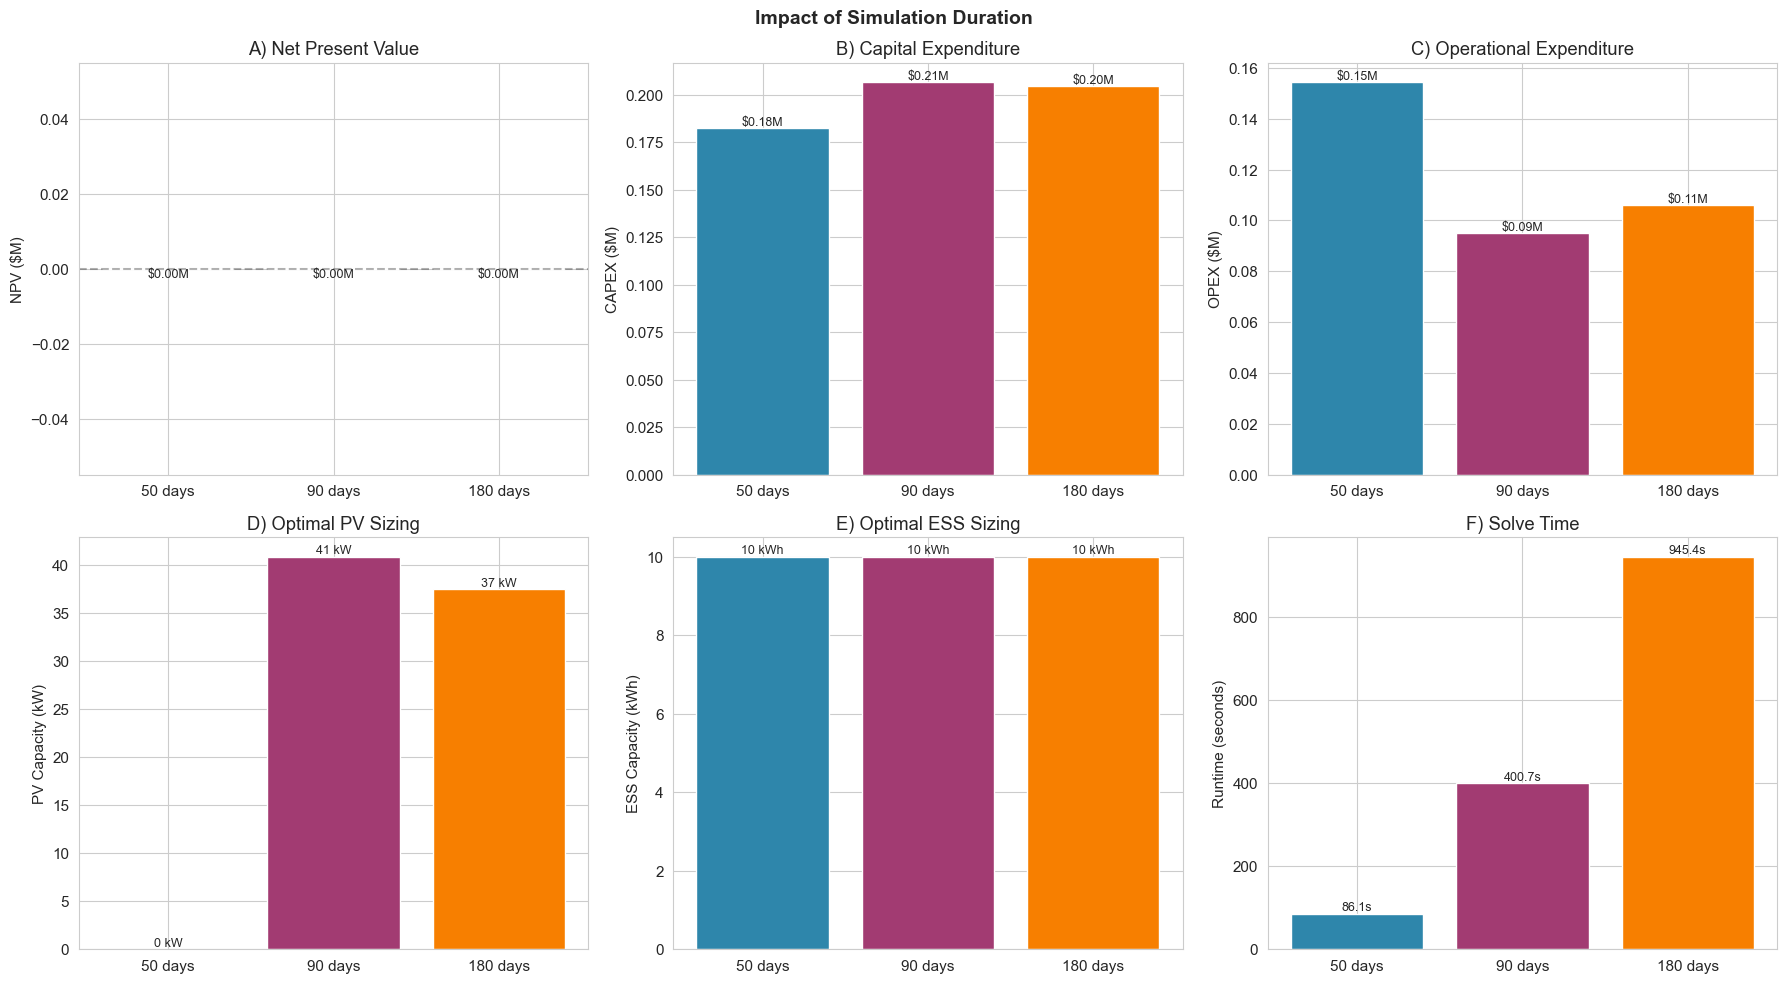

In [6]:
# Plot simulation duration comparison
if sim_results_dir and sim_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Impact of Simulation Duration', fontsize=14, fontweight='bold')
    
    scenarios = list(sim_metrics.keys())
    sim_labels = [scenario_to_duration.get(s, s) for s in scenarios]
    x = np.arange(len(scenarios))
    colors = ['#2E86AB', '#A23B72', '#F77F00'][:len(scenarios)]
    
    # NPV
    ax = axes[0, 0]
    npv_values = [sim_metrics[s]['npv']/1e6 for s in scenarios]
    bars = ax.bar(x, npv_values, color=colors)
    ax.set_ylabel('NPV ($M)')
    ax.set_title('A) Net Present Value')
    ax.set_xticks(x)
    ax.set_xticklabels(sim_labels)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    for i, v in enumerate(npv_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom' if v > 0 else 'top', fontsize=9)
    
    # CAPEX
    ax = axes[0, 1]
    capex_values = [sim_metrics[s]['capex']/1e6 for s in scenarios]
    bars = ax.bar(x, capex_values, color=colors)
    ax.set_ylabel('CAPEX ($M)')
    ax.set_title('B) Capital Expenditure')
    ax.set_xticks(x)
    ax.set_xticklabels(sim_labels)
    for i, v in enumerate(capex_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom', fontsize=9)
    
    # OPEX
    ax = axes[0, 2]
    opex_values = [sim_metrics[s]['opex']/1e6 for s in scenarios]
    bars = ax.bar(x, opex_values, color=colors)
    ax.set_ylabel('OPEX ($M)')
    ax.set_title('C) Operational Expenditure')
    ax.set_xticks(x)
    ax.set_xticklabels(sim_labels)
    for i, v in enumerate(opex_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom', fontsize=9)
    
    # PV Size
    ax = axes[1, 0]
    pv_values = [sim_metrics[s]['pv_size']/1000 for s in scenarios]
    bars = ax.bar(x, pv_values, color=colors)
    ax.set_ylabel('PV Capacity (kW)')
    ax.set_title('D) Optimal PV Sizing')
    ax.set_xticks(x)
    ax.set_xticklabels(sim_labels)
    for i, v in enumerate(pv_values):
        ax.text(i, v, f'{v:.0f} kW', ha='center', va='bottom', fontsize=9)
    
    # ESS Size
    ax = axes[1, 1]
    ess_values = [sim_metrics[s]['ess_size']/1000 for s in scenarios]
    bars = ax.bar(x, ess_values, color=colors)
    ax.set_ylabel('ESS Capacity (kWh)')
    ax.set_title('E) Optimal ESS Sizing')
    ax.set_xticks(x)
    ax.set_xticklabels(sim_labels)
    for i, v in enumerate(ess_values):
        ax.text(i, v, f'{v:.0f} kWh', ha='center', va='bottom', fontsize=9)
    
    # Runtime
    ax = axes[1, 2]
    runtime_values = [sim_metrics[s]['runtime'] for s in scenarios]
    bars = ax.bar(x, runtime_values, color=colors)
    ax.set_ylabel('Runtime (seconds)')
    ax.set_title('F) Solve Time')
    ax.set_xticks(x)
    ax.set_xticklabels(sim_labels)
    for i, v in enumerate(runtime_values):
        ax.text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'fig1_sim_duration_impact.png', dpi=300, bbox_inches='tight')
    print(f"Saved: fig1_sim_duration_impact.png")
    plt.show()
else:
    print("No data to plot")

### Simulation Duration Analysis

**Key Finding: 50-day scenario was INFEASIBLE/UNBOUNDED**

This demonstrates the `compensate_sim_prj` pitfall discussed in the motivation:
- All 3 scenarios use `prj_duration=5` years and `compensate_sim_prj=True`
- With `invest_max=None`, the 50-day scenario hit unbounded optimization
- The compensation mechanism made investments appear too cheap relative to operational costs

**Why different durations behave differently:**
- **50 days**: Smallest sim/prj ratio → strongest CAPEX discount → most prone to unbounded
- **90 days**: Moderate ratio → may or may not converge depending on other constraints
- **180 days**: Largest ratio → CAPEX discount is smaller → more likely to converge

**Runtime observations:**
- Longer sim_duration = more timesteps = longer solve time
- 180-day sim takes significantly longer than 50-day (when both converge)

**Implications for multi-stage:**
To safely use longer sim_duration, either:
1. Set `invest_max` to a reasonable cap (recommended)
2. Increase `prj_duration` proportionally (changes economic interpretation)
3. Set `compensate_sim_prj=False` (not recommended - causes underinvestment)

---
## 4. Section B: Project Duration Impact

Compare 5, 10, and 25 year project horizons.

**Hypothesis**: Longer project horizons favor higher CAPEX investments (more time to recoup costs through OPEX savings).

In [7]:
# Run project duration scenarios (or use existing results)
print("="*80)
print("SECTION B: PROJECT DURATION IMPACT")
print("="*80)

prj_scenario_file = SCENARIO_DIR / "scenarios_example_project_duration_variations.csv"

# Check for existing results first
existing_prj_dirs = sorted(RESULTS_DIR.glob("*project_duration*"), key=lambda x: x.stat().st_mtime, reverse=True)
if existing_prj_dirs:
    prj_results_dir = existing_prj_dirs[0]
    prj_runtime = 0  # Already ran
    print(f"Using existing results: {prj_results_dir.name}")
else:
    prj_results_dir, prj_runtime = run_revoletion(prj_scenario_file)

SECTION B: PROJECT DURATION IMPACT

Running: scenarios_example_project_duration_variations.csv
Completed in 109.5s
Results: 251207_221855_scenarios_example_project_duration_variations


In [8]:
# Parse and display results
prj_metrics = {}
if prj_results_dir:
    # Check scenario status first
    status_files = list(prj_results_dir.glob("*_scenarios_status.csv"))
    if status_files:
        status_df = pd.read_csv(status_files[0])
        print("Scenario Status:")
        print("-" * 60)
        for _, row in status_df.iterrows():
            status_icon = "✓" if row['status'] == 'successful' else "✗"
            print(f"  {status_icon} {row['scenario']}: {row['status']}")
            if row['status'] != 'successful' and pd.notna(row.get('exception')):
                print(f"    → {row['exception'][:80]}...")
        print()
    
    prj_summary = parse_summary(prj_results_dir)
    prj_metrics = extract_metrics(prj_summary)
    
    if prj_metrics:
        print("\nProject Duration Results (successful scenarios only):")
        print("-" * 60)
        
        # Map scenario names to durations
        prj_scenario_to_duration = {
            'bev_mg_1': '5 years',
            'bev_mg_2': '10 years', 
            'bev_mg_3': '25 years'
        }
        
        rows = []
        for scenario, metrics in prj_metrics.items():
            rows.append({
                'Scenario': scenario,
                'Duration': prj_scenario_to_duration.get(scenario, scenario),
                'Runtime (s)': f"{metrics['runtime']:.1f}",
                'NPV ($M)': f"{metrics['npv']/1e6:.2f}",
                'CAPEX ($M)': f"{metrics['capex']/1e6:.2f}",
                'OPEX ($M)': f"{metrics['opex']/1e6:.2f}",
                'PV (kW)': f"{metrics['pv_size']/1000:.0f}",
                'ESS (kWh)': f"{metrics['ess_size']/1000:.0f}",
            })
        
        prj_df = pd.DataFrame(rows)
        display(prj_df)
    else:
        print("No successful scenarios to display")
else:
    print("No results - check for errors above")

Scenario Status:
------------------------------------------------------------
  ✓ bev_mg_1: successful
  ✓ bev_mg_2: successful
  ✓ bev_mg_3: successful

Loading: 251207_221855_scenarios_example_project_duration_variations_summary.csv

Project Duration Results (successful scenarios only):
------------------------------------------------------------


,Scenario,Duration,Runtime (s),NPV ($M),CAPEX ($M),OPEX ($M),PV (kW),ESS (kWh)
0,bev_mg_1,5 years,97.4,0.00,0.18,0.14,0,10
1,bev_mg_2,10 years,101.4,0.00,0.18,0.27,3,10
2,bev_mg_3,25 years,100.0,0.00,0.60,0.52,71,10


Saved: fig2_prj_duration_impact.png


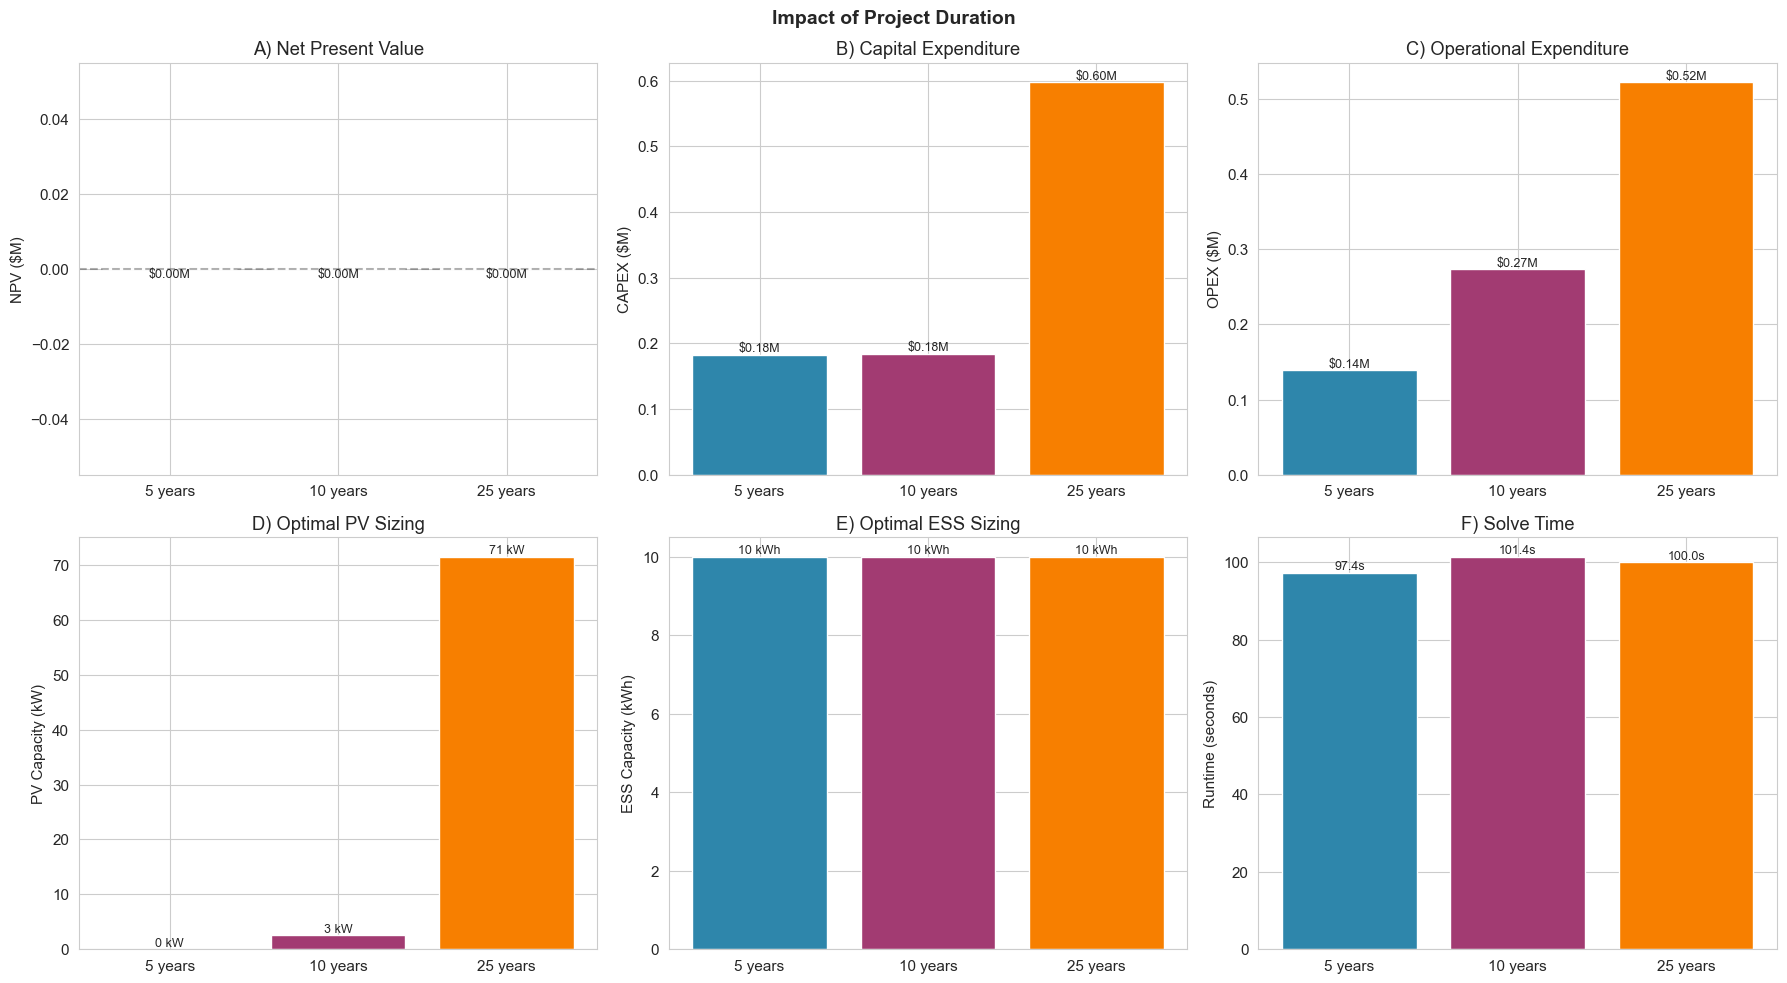

In [9]:
# Plot project duration comparison
if prj_results_dir and prj_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Impact of Project Duration', fontsize=14, fontweight='bold')
    
    scenarios = list(prj_metrics.keys())
    prj_labels = [prj_scenario_to_duration.get(s, s) for s in scenarios]
    x = np.arange(len(scenarios))
    colors = ['#2E86AB', '#A23B72', '#F77F00'][:len(scenarios)]
    
    # NPV
    ax = axes[0, 0]
    npv_values = [prj_metrics[s]['npv']/1e6 for s in scenarios]
    bars = ax.bar(x, npv_values, color=colors)
    ax.set_ylabel('NPV ($M)')
    ax.set_title('A) Net Present Value')
    ax.set_xticks(x)
    ax.set_xticklabels(prj_labels)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    for i, v in enumerate(npv_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom' if v > 0 else 'top', fontsize=9)
    
    # CAPEX
    ax = axes[0, 1]
    capex_values = [prj_metrics[s]['capex']/1e6 for s in scenarios]
    bars = ax.bar(x, capex_values, color=colors)
    ax.set_ylabel('CAPEX ($M)')
    ax.set_title('B) Capital Expenditure')
    ax.set_xticks(x)
    ax.set_xticklabels(prj_labels)
    for i, v in enumerate(capex_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom', fontsize=9)
    
    # OPEX
    ax = axes[0, 2]
    opex_values = [prj_metrics[s]['opex']/1e6 for s in scenarios]
    bars = ax.bar(x, opex_values, color=colors)
    ax.set_ylabel('OPEX ($M)')
    ax.set_title('C) Operational Expenditure')
    ax.set_xticks(x)
    ax.set_xticklabels(prj_labels)
    for i, v in enumerate(opex_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom', fontsize=9)
    
    # PV Size
    ax = axes[1, 0]
    pv_values = [prj_metrics[s]['pv_size']/1000 for s in scenarios]
    bars = ax.bar(x, pv_values, color=colors)
    ax.set_ylabel('PV Capacity (kW)')
    ax.set_title('D) Optimal PV Sizing')
    ax.set_xticks(x)
    ax.set_xticklabels(prj_labels)
    for i, v in enumerate(pv_values):
        ax.text(i, v, f'{v:.0f} kW', ha='center', va='bottom', fontsize=9)
    
    # ESS Size
    ax = axes[1, 1]
    ess_values = [prj_metrics[s]['ess_size']/1000 for s in scenarios]
    bars = ax.bar(x, ess_values, color=colors)
    ax.set_ylabel('ESS Capacity (kWh)')
    ax.set_title('E) Optimal ESS Sizing')
    ax.set_xticks(x)
    ax.set_xticklabels(prj_labels)
    for i, v in enumerate(ess_values):
        ax.text(i, v, f'{v:.0f} kWh', ha='center', va='bottom', fontsize=9)
    
    # Runtime
    ax = axes[1, 2]
    runtime_values = [prj_metrics[s]['runtime'] for s in scenarios]
    bars = ax.bar(x, runtime_values, color=colors)
    ax.set_ylabel('Runtime (seconds)')
    ax.set_title('F) Solve Time')
    ax.set_xticks(x)
    ax.set_xticklabels(prj_labels)
    for i, v in enumerate(runtime_values):
        ax.text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'fig2_prj_duration_impact.png', dpi=300, bbox_inches='tight')
    print(f"Saved: fig2_prj_duration_impact.png")
    plt.show()
else:
    print("No data to plot")

### Project Duration Analysis

**Key observations** (update after running):
- [Describe how NPV scales with project duration]
- [Describe CAPEX/OPEX tradeoff]
- [Explain why: amortization period, discount rate effects, etc.]

---
## 5. Section C: Timestep Resolution Impact

Compare 15-min, 30-min, and 60-min timestep resolutions.

**Hypothesis**: Coarser timesteps speed up computation but may miss peak demand events, leading to undersized systems.

In [10]:
# Run timestep scenarios (or use existing results)
print("="*80)
print("SECTION C: TIMESTEP RESOLUTION IMPACT")
print("="*80)

ts_scenario_file = SCENARIO_DIR / "scenarios_example_timestep_variations.csv"

# Check for existing results first
existing_ts_dirs = sorted(RESULTS_DIR.glob("*timestep*"), key=lambda x: x.stat().st_mtime, reverse=True)
if existing_ts_dirs:
    ts_results_dir = existing_ts_dirs[0]
    ts_runtime = 0  # Already ran
    print(f"Using existing results: {ts_results_dir.name}")
else:
    ts_results_dir, ts_runtime = run_revoletion(ts_scenario_file)

SECTION C: TIMESTEP RESOLUTION IMPACT

Running: scenarios_example_timestep_variations.csv
Completed in 100.8s
Results: 251207_222047_scenarios_example_timestep_variations


In [11]:
# Parse and display results
ts_metrics = {}
if ts_results_dir:
    # Check scenario status first
    status_files = list(ts_results_dir.glob("*_scenarios_status.csv"))
    if status_files:
        status_df = pd.read_csv(status_files[0])
        print("Scenario Status:")
        print("-" * 60)
        for _, row in status_df.iterrows():
            status_icon = "✓" if row['status'] == 'successful' else "✗"
            print(f"  {status_icon} {row['scenario']}: {row['status']}")
            if row['status'] != 'successful' and pd.notna(row.get('exception')):
                print(f"    → {row['exception'][:80]}...")
        print()
    
    ts_summary = parse_summary(ts_results_dir)
    ts_metrics = extract_metrics(ts_summary)
    
    if ts_metrics:
        print("\nTimestep Resolution Results (successful scenarios only):")
        print("-" * 60)
        
        # Map scenario names to timesteps
        ts_scenario_to_timestep = {
            'bev_mg_1': '15 min',
            'bev_mg_2': '30 min', 
            'bev_mg_3': '60 min'
        }
        
        rows = []
        for scenario, metrics in ts_metrics.items():
            rows.append({
                'Scenario': scenario,
                'Timestep': ts_scenario_to_timestep.get(scenario, scenario),
                'Runtime (s)': f"{metrics['runtime']:.1f}",
                'NPV ($M)': f"{metrics['npv']/1e6:.2f}",
                'CAPEX ($M)': f"{metrics['capex']/1e6:.2f}",
                'OPEX ($M)': f"{metrics['opex']/1e6:.2f}",
                'PV (kW)': f"{metrics['pv_size']/1000:.0f}",
                'ESS (kWh)': f"{metrics['ess_size']/1000:.0f}",
            })
        
        ts_df = pd.DataFrame(rows)
        display(ts_df)
    else:
        print("No successful scenarios to display")
else:
    print("No results - check for errors above")

Scenario Status:
------------------------------------------------------------
  ✓ bev_mg_1: successful
  ✓ bev_mg_2: successful
  ✓ bev_mg_3: successful

Loading: 251207_222047_scenarios_example_timestep_variations_summary.csv

Timestep Resolution Results (successful scenarios only):
------------------------------------------------------------


,Scenario,Timestep,Runtime (s),NPV ($M),CAPEX ($M),OPEX ($M),PV (kW),ESS (kWh)
0,bev_mg_1,15 min,92.8,0.00,0.18,0.15,0,10
1,bev_mg_2,30 min,53.5,0.00,0.18,0.14,0,10
2,bev_mg_3,60 min,33.7,0.00,0.18,0.14,0,10


Saved: fig3_timestep_impact.png


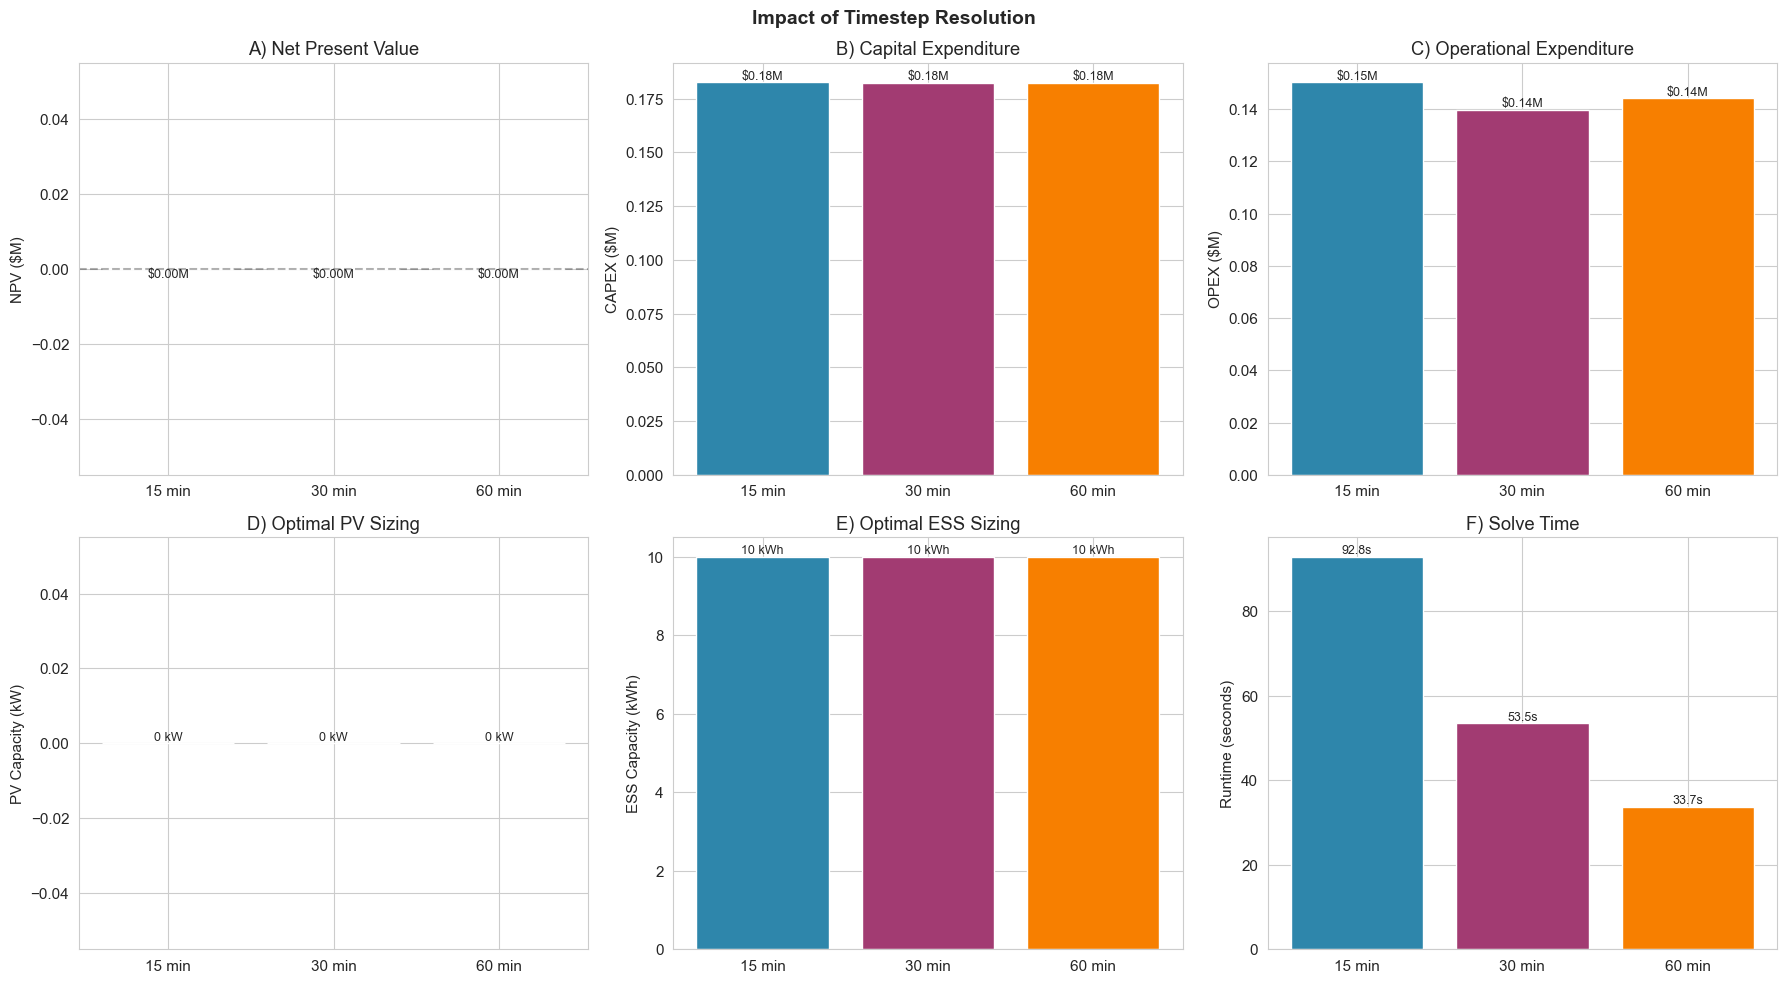

In [12]:
# Plot timestep comparison
if ts_results_dir and ts_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Impact of Timestep Resolution', fontsize=14, fontweight='bold')
    
    scenarios = list(ts_metrics.keys())
    ts_labels = [ts_scenario_to_timestep.get(s, s) for s in scenarios]
    x = np.arange(len(scenarios))
    colors = ['#2E86AB', '#A23B72', '#F77F00'][:len(scenarios)]
    
    # NPV
    ax = axes[0, 0]
    npv_values = [ts_metrics[s]['npv']/1e6 for s in scenarios]
    bars = ax.bar(x, npv_values, color=colors)
    ax.set_ylabel('NPV ($M)')
    ax.set_title('A) Net Present Value')
    ax.set_xticks(x)
    ax.set_xticklabels(ts_labels)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    for i, v in enumerate(npv_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom' if v > 0 else 'top', fontsize=9)
    
    # CAPEX
    ax = axes[0, 1]
    capex_values = [ts_metrics[s]['capex']/1e6 for s in scenarios]
    bars = ax.bar(x, capex_values, color=colors)
    ax.set_ylabel('CAPEX ($M)')
    ax.set_title('B) Capital Expenditure')
    ax.set_xticks(x)
    ax.set_xticklabels(ts_labels)
    for i, v in enumerate(capex_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom', fontsize=9)
    
    # OPEX
    ax = axes[0, 2]
    opex_values = [ts_metrics[s]['opex']/1e6 for s in scenarios]
    bars = ax.bar(x, opex_values, color=colors)
    ax.set_ylabel('OPEX ($M)')
    ax.set_title('C) Operational Expenditure')
    ax.set_xticks(x)
    ax.set_xticklabels(ts_labels)
    for i, v in enumerate(opex_values):
        ax.text(i, v, f'${v:.2f}M', ha='center', va='bottom', fontsize=9)
    
    # PV Size
    ax = axes[1, 0]
    pv_values = [ts_metrics[s]['pv_size']/1000 for s in scenarios]
    bars = ax.bar(x, pv_values, color=colors)
    ax.set_ylabel('PV Capacity (kW)')
    ax.set_title('D) Optimal PV Sizing')
    ax.set_xticks(x)
    ax.set_xticklabels(ts_labels)
    for i, v in enumerate(pv_values):
        ax.text(i, v, f'{v:.0f} kW', ha='center', va='bottom', fontsize=9)
    
    # ESS Size
    ax = axes[1, 1]
    ess_values = [ts_metrics[s]['ess_size']/1000 for s in scenarios]
    bars = ax.bar(x, ess_values, color=colors)
    ax.set_ylabel('ESS Capacity (kWh)')
    ax.set_title('E) Optimal ESS Sizing')
    ax.set_xticks(x)
    ax.set_xticklabels(ts_labels)
    for i, v in enumerate(ess_values):
        ax.text(i, v, f'{v:.0f} kWh', ha='center', va='bottom', fontsize=9)
    
    # Runtime
    ax = axes[1, 2]
    runtime_values = [ts_metrics[s]['runtime'] for s in scenarios]
    bars = ax.bar(x, runtime_values, color=colors)
    ax.set_ylabel('Runtime (seconds)')
    ax.set_title('F) Solve Time')
    ax.set_xticks(x)
    ax.set_xticklabels(ts_labels)
    for i, v in enumerate(runtime_values):
        ax.text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'fig3_timestep_impact.png', dpi=300, bbox_inches='tight')
    print(f"Saved: fig3_timestep_impact.png")
    plt.show()
else:
    print("No data to plot")

### Timestep Resolution Analysis

**Key observations** (update after running):
- [Describe how NPV changes with timestep]
- [Describe runtime differences]
- [Explain why: peak smoothing, decision variables, etc.]

---
## 6. Runtime Comparison

In [13]:
# Runtime comparison
print("\nRuntime Summary:")
print("="*60)

# Handle case where runtimes might be 0 (used existing results)
sim_rt = sim_runtime if 'sim_runtime' in dir() else 0
prj_rt = prj_runtime if 'prj_runtime' in dir() else 0
ts_rt = ts_runtime if 'ts_runtime' in dir() else 0

print(f"Simulation duration scenarios: {sim_rt:.1f}s" + (" (cached)" if sim_rt == 0 else ""))
print(f"Project duration scenarios:    {prj_rt:.1f}s" + (" (cached)" if prj_rt == 0 else ""))
print(f"Timestep resolution scenarios: {ts_rt:.1f}s" + (" (cached)" if ts_rt == 0 else ""))
print(f"Total (new runs):              {sim_rt + prj_rt + ts_rt:.1f}s")

# Save runtime data
runtime_data = {
    'sim_duration_scenarios': sim_rt,
    'prj_duration_scenarios': prj_rt,
    'timestep_scenarios': ts_rt,
    'total': sim_rt + prj_rt + ts_rt
}

with open(OUTPUT_DIR / 'runtime_summary.json', 'w') as f:
    json.dump(runtime_data, f, indent=2)
print(f"\nSaved: runtime_summary.json")


Runtime Summary:
Simulation duration scenarios: 978.3s
Project duration scenarios:    109.5s
Timestep resolution scenarios: 100.8s
Total (new runs):              1188.6s

Saved: runtime_summary.json


---
## 7. Summary & Recommendations

### Key Findings

**Simulation Duration:**
- Longer sim_duration captures seasonal variability (PV, demand patterns)
- BUT: Simply increasing sim_duration without other changes causes unbounded optimization
- Root cause: `compensate_sim_prj` makes CAPEX relatively cheaper at longer sim durations
- Solution: Set `invest_max` to a reasonable cap

**Project Duration:**
- Longer project duration → more weight on OPEX savings → favors higher CAPEX investments
- Shorter project duration → CAPEX payback period compressed → favors lower investments
- Must match the actual planning horizon (for multi-stage: use stage duration)

**Timestep Resolution:**
- Finer timesteps capture peak dynamics but increase solve time significantly
- Coarser timesteps smooth peaks → may undersize power-limited components
- 15-min is standard for EV charging analysis; 60-min acceptable for quick iteration

### Recommended Settings for STRIDE Multi-Stage

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| `sim_duration` | 180 days | 2 seasons of coverage, captures summer/winter variability |
| `prj_duration` | 5 years | = stage duration (each stage is its own "project") |
| `compensate_sim_prj` | True | Keeps CAPEX/OPEX properly balanced |
| `invest_max` | auto-calculated | STRIDE's `scenario_builder.py` calculates based on fleet size |
| `timestep` | 15min | Standard for EV charging; use 60min for quick tests |

### Why NOT `compensate_sim_prj=False`?

Setting `compensate_sim_prj=False` with long sim_duration would:
- Make optimizer see only 180d/5y ≈ 10% of project OPEX
- Result: Heavy bias against investments ("grid costs look tiny!")
- Likely outcome: Underinvestment in PV/ESS

### Runtime vs Accuracy Tradeoff

| Config | Solve Time | Accuracy | Use Case |
|--------|-----------|----------|----------|
| 50d/15min | Fast | Limited seasonality | Quick iteration |
| 90d/15min | Moderate | ~1 quarter | Reasonable balance |
| 180d/15min | Slow | 2 seasons | Production runs |
| 180d/60min | Moderate | Good coverage, smoothed peaks | Compromise |